The aim of this notebook is to understand the various learnt latent factors.

In [1]:
import numpy as np
import pandas as pd
import sys
from common import compute_rmse_fraction


In [3]:
from mf_core import *

import numpy as np
import pandas as pd
import sys
from create_matrix import *
from sklearn.model_selection import LeaveOneOut
from scipy.optimize import nnls

import pickle
from tensor_custom_core import *
from degree_days import dds


APPLIANCES = ['hvac']
region = "Austin"
year = 2014

def un_normalize(x, maximum, minimum):
    return (maximum-minimum)*x + minimum


a, b = 3, 3

print a, b


pred = {}
lat = {}
for appliance in APPLIANCES[:]:
    lat[appliance] = {}
    pred[appliance] = {}
    if appliance == "hvac":
        start, stop = 5, 11
    else:
        start, stop = 1, 13
    months = stop - start
    pred[appliance] = {}
    appliance_df = create_matrix_region_appliance_year(region, year, appliance)
    aggregate_cols = [x for x in appliance_df.columns if "aggregate" in x]
    appliance_cols = [x for x in appliance_df.columns if appliance in x]
    energy_cols = np.concatenate([aggregate_cols, appliance_cols])

    df = appliance_df.copy()
    dfc = df.copy()
    static_cols = ['area', 'total_occupants', 'num_rooms']
    static_df = df[static_cols]
    static_df = static_df.div(static_df.max())
    weather_values = np.array(dds[2014]['Austin'][start-1:stop-1]).reshape(-1,1)

    df = df[energy_cols]
    col_max = df.max().max()
    col_min = df.min().min()
    df = (1.0*(df-col_min))/(col_max-col_min)
    tensor = df.values.reshape((len(df), 2, months))
    M, N, O = tensor.shape
    mask = np.ones(M).astype('bool')

    case=2
    pred[appliance][case] = {}
    for a in range(1, 6):
        lat[appliance][a] = {}
        print "*"*20
        print a, case, appliance
        print "*"*20

        b = a
        pred[appliance][case][a] = {}
        for i, home in enumerate(df.index[:1]):


            tensor_copy = tensor.copy()
            tensor_copy[i, 1, :]=np.NaN
            H, A, T = learn_HAT(case, tensor_copy, a, a, num_iter=2000, lr=0.1, dis=False, cost_function='rel',
                                H_known=static_df.values[:,:a])
            lat[appliance][a]['T'] = T
            lat[appliance][a]['A'] = A
            lat[appliance][a]['H'] = H
            
            

3 3
********************
1 2 hvac
********************
********************
2 2 hvac
********************
********************
3 2 hvac
********************
********************
4 2 hvac
********************
********************
5 2 hvac
********************


In [4]:
%matplotlib inline

In [5]:
import seaborn as sns

In [6]:
dds[2014]['Austin']

[0.012706480304955527,
 0.07369758576874205,
 0.09148665819567979,
 0.30495552731893266,
 0.5184243964421855,
 0.832274459974587,
 0.9085133418043202,
 1.0,
 0.747141041931385,
 0.4650571791613723,
 0.054637865311308764,
 0.03430749682337993]

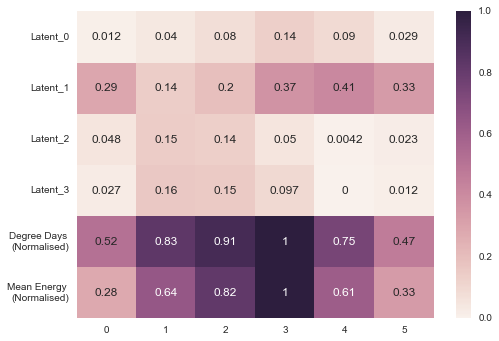

In [8]:
def append_weather(df, appliance):
    if appliance=="hvac":
        start, stop = 5, 11
    else:
        start, stop = 1, 13
    degree_days = dds[2014]['Austin'][start-1:stop-1]
    df.loc['Degree Days \n(Normalised)'] = degree_days
    return df

def append_mean_energy(df, appliance):
    appliance_df = create_matrix_region_appliance_year(region, year, appliance)
    appliance_cols = [x for x in appliance_df.columns if appliance in x]
    appliance_df = appliance_df[appliance_cols]
    appliance_df.columns = range(len(appliance_cols))
    appliance_energy = appliance_df.mean().div(appliance_df.mean().max())
    df.loc['Mean Energy \n(Normalised)'] = appliance_energy
    return df
    

appliance="hvac"
num_factors=4
df = pd.DataFrame(lat[appliance][num_factors]['T']).T
df.index = ['Latent_'+str(x) for x in df.index]
df = append_weather(df, appliance)
df = append_mean_energy(df, appliance)

sns.heatmap(df, annot=True)

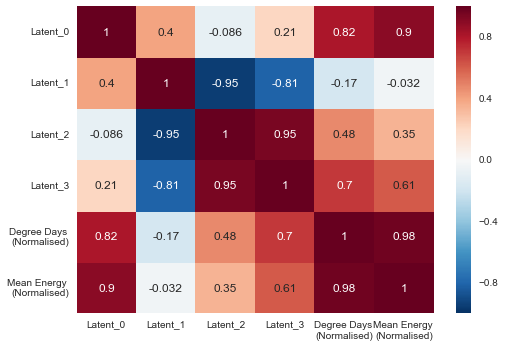

In [9]:
sns.heatmap(df.T.corr(), annot=True)